<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Thoughts" data-toc-modified-id="Thoughts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thoughts</a></span></li></ul></div>

In [1]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

# computer vision
import torchvision
from torchvision import transforms
from PIL import Image

# dataset loading
from torch.utils.data import Dataset, DataLoader

# convenient package for plotting loss functions
# from livelossplot import PlotLosses

import copy
# import tqdm

In [2]:
# Run script for simulated data
import importlib.util

system_path = r"C:\Users\uniqu\Adaptation\github repos" \
              + "\Bioinformatics-Neural Networks for Genomic Risk"
local_path = "\simulate_twas.py"
path = system_path + local_path

exec(open(path).read())
(beta1, beta2, beta3) = (beta for beta in betas)

genos_only.shape: (5000, 100)
phenos_only.shape: (5000,)
genos_plus.shape: (500, 100)
exprs_plus.shape: (500, 10)
phenos_plus.shape: (500,)
beta0.shape (100, 10)
beta1.shape (10,)
beta2.shape (100,)


In [3]:
# turn 1D arrays to column vectors
variables = [genos_only, phenos_only, genos_plus, exprs_plus, phenos_plus]

for idx, var in enumerate(variables):
    if var.ndim == 1:
        variables[idx] = np.reshape(variables[idx], newshape=(-1,1))
[genos_only, phenos_only, genos_plus, exprs_plus, phenos_plus] = variables

betas = list(betas)
for idx, beta in enumerate(betas):
    if var.ndim == 1:
        betas[idx] = np.reshape(betas[idx], newshape=(-1,1))

print_shapes()

genos_only.shape: (5000, 100)
phenos_only.shape: (5000, 1)
genos_plus.shape: (500, 100)
exprs_plus.shape: (500, 10)
phenos_plus.shape: (500, 1)
beta0.shape (1000, 1)
beta1.shape (10, 1)
beta2.shape (100, 1)


In [4]:
# Perform train-test split
X, Y = genos_only, phenos_only
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=7)

In [5]:
class simulated_Dataset(Dataset): # inherit from torch's Dataset class.
    def __init__(self, train):
        # data loading
        if train == True:
            self.X = torch.from_numpy(X_train.astype(np.float32))
            self.Y = torch.from_numpy(Y_train.astype(np.float32))
        else:
            self.X = torch.from_numpy(X_test.astype(np.float32))
            self.Y = torch.from_numpy(Y_test.reshape(-1,1).astype(np.float32))

        if self.X.shape[0] == self.Y.shape[0]:
            self.n_samples = self.X.shape[0]
        else:
            raise ValueError("Shape mismatch")
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return self.n_samples

BATCH_SIZE = 60

train_set = simulated_Dataset(train=True)
test_set = simulated_Dataset(train=False)

train_dl = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

for data in train_dl:
    features, labels = data
    print(features.shape, labels.shape)
    break
print(f"Shape of single feature: {data[0][0].shape}") # 1D tensor
print(f"Shape of single target: {data[1][0].shape}") # 0D tensor (scalar)

n_features = torch.flatten(data[0][0]).shape[0]

torch.Size([60, 100]) torch.Size([60, 1])
Shape of single feature: torch.Size([100])
Shape of single target: torch.Size([1])


In [6]:
class Sequential_Net(nn.Module): # class inherits from nn.Module
    def __init__(self):
        super(Sequential_Net, self).__init__() # initialize nn.Module
        # some fully connected layers w/ linear transformation
        """ nn.Linear(in_features, out_features, bias=True)
        Args:
            in_features: size of each input sample. For input shape (28, 28), 
                we would have in_features = 28 * 28 = 784
            out_features: size of each output sample.
        """
        self.fc1 = nn.Linear(n_features, 70)
        self.fc2 = nn.Linear(70, 30)
        self.fc3 = nn.Linear(30, 1)
    def forward(self, x): # defines the forward propagation
        x = F.relu(self.fc1(x)) # relu activation function
        x = F.relu(self.fc2(x)) 
        x = F.leaky_relu(self.fc3(x))
        return x

In [7]:
def train(network, loss_fn, train_loader, val_loader,
          n_epochs, optimizer, device):
    """

    Args:
        network (nn.Module-like): NN object
        loss_fn: loss function
        train_loader (DataLoader): PyTorch DataLoader for training set
        val_loader (DataLoader): PyTorch DataLoader for validation set
        n_epochs (int): number of epochs := # of full passes through data
        optimizer (torch.optim optimizer): SGD, Adam, etc.
        device (torch.device, optional): GPU selection. OR, uses CPU.
    """

    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Training
        network.train()
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad() # clears gradient buffers of all parameters
            inputs, targets = batch
            # transfer batch data to computation device
            [inputs, targets] = [tensor.to(device) for tensor in [inputs, targets]]
            output = network(inputs)
            loss = loss_fn(output, targets)
            # back propagation
            loss.backward()
            optimizer.step() # update model weights
            train_loss += loss.data.item()
        # train_loss /= len(train_iterator)
        train_losses.append(train_loss)
    
        if idx % 10 == 0:
            print(f"epoch {epoch+1}/{n_epochs}, batch {idx}.")
        
        # Validation 
        network.eval()        
        for batch in val_loader:
            inputs, targets = batch
            [inputs, targets] = [tensor.to(device) for tensor in batch]
            output = network(inputs)
            loss = loss_fn(output, targets)
            val_loss += loss.data.item()
        # val_loss /= len(valid_iterator)
        val_losses.append(val_loss)
    
        print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, "
             +f"Validation loss: {val_loss:.3f}")

    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.plot(np.arange(n_epochs), train_losses, '-')
    ax.plot(np.arange(n_epochs), val_losses, '-')
    ax.legend()
    plt.show()

```python
# TODO: Implement this later and change to a script instead of a notebook.
def main():
    network = Sequential_Net()
    print(network)
    
    
if __name__ == "__main__":
    main()
```

Sequential_Net(
  (fc1): Linear(in_features=100, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
)
Epoch: 0, Training Loss: 17.845, Validation loss: 6.674
Epoch: 1, Training Loss: 14.000, Validation loss: 6.686
Epoch: 2, Training Loss: 13.261, Validation loss: 6.640
Epoch: 3, Training Loss: 12.529, Validation loss: 7.009
Epoch: 4, Training Loss: 11.427, Validation loss: 7.202
Epoch: 5, Training Loss: 10.420, Validation loss: 7.513
Epoch: 6, Training Loss: 9.072, Validation loss: 8.118
Epoch: 7, Training Loss: 7.956, Validation loss: 8.711
Epoch: 8, Training Loss: 6.693, Validation loss: 9.183
Epoch: 9, Training Loss: 5.618, Validation loss: 9.292
Epoch: 10, Training Loss: 4.328, Validation loss: 9.282
Epoch: 11, Training Loss: 3.822, Validation loss: 9.983
Epoch: 12, Training Loss: 3.276, Validation loss: 9.815
Epoch: 13, Training Loss: 2.727, Validation loss: 10.376
Epoch: 14, Training L

No handles with labels found to put in legend.


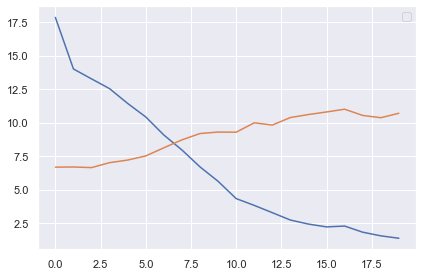

In [8]:
def main():
    network = Sequential_Net()
    print(network)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
    
    # GPU for cloud training
    if torch.cuda.is_available(): # If PyTorch reports that GPU is available
        device = torch.device("cuda") # device = GPU
    else:
        device = torch.device("cpu") # device = CPU

    network = network.to(device) # Copy model to device
    
    # Train and Evaluate
    train(network=network, loss_fn=loss_fn, optimizer=optimizer,
          train_loader=train_dl, val_loader=test_dl, n_epochs=20, 
          device=device)
    
    # Save model 
    system_path = r"C:/Users/uniqu/Adaptation/github repos" \
                  + "/Bioinformatics-Neural Networks for Genomic Risk"
    local_path = "/temp/saved_weights"
    path = system_path + local_path
    torch.save(network.state_dict(), path)
    
    # Load model
    # network_state_dict = torch.load(path)
    # new_net = Sequential_Net()
    # new_net.load_state_dict(network_state_dict)

main()

Definitely overtraining.
### Thoughts
- Add dropout layers
- Add regularization term
- How do I use exprs?